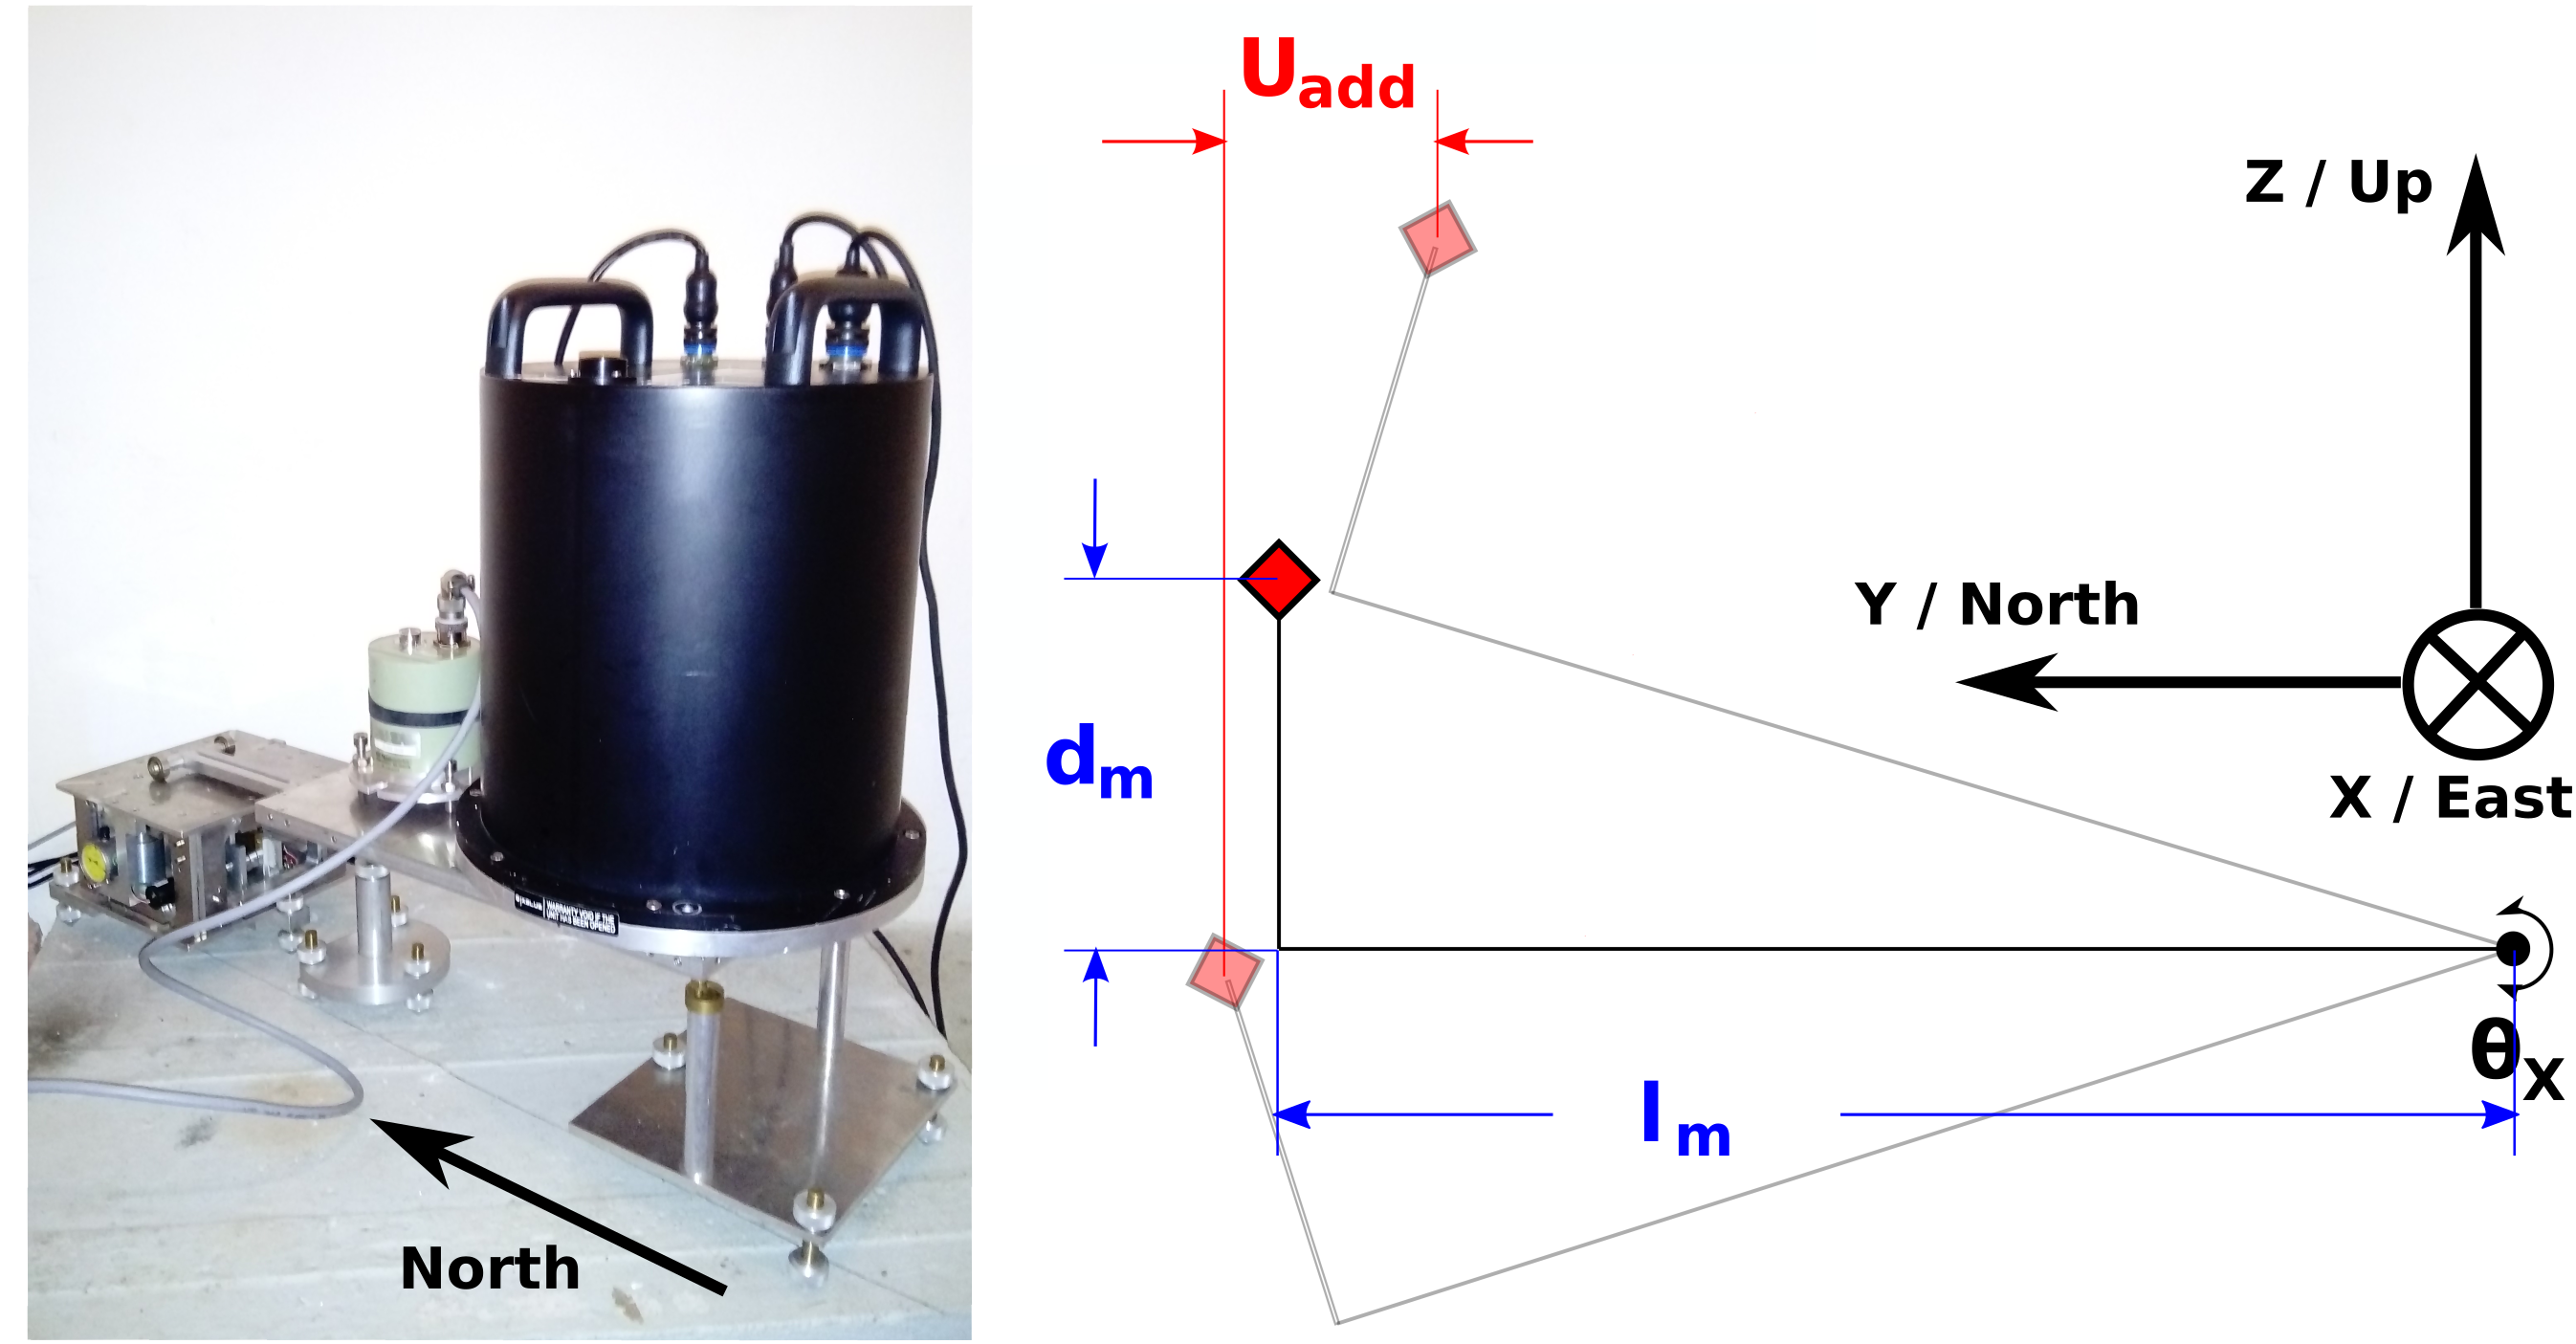

In [1]:
import numpy as np
import math as M

from matplotlib import pyplot as plt
from obspy import *

from tilt_utils import get_data, trigger, find_nearest, calc_residual_disp, get_angle, theo_resid_disp, calc_height_of_mass
from remove_tilt_coh import remove_tilt_coh
from remove_tilt_time import remove_tilt_time

from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)

Just some special functions to get nice plots

In [2]:
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.0,
        }

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.0}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        #loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

set some experiment specific parameters

In [3]:
##################################
# TEST 3   - tilt table -        #
#          - high gain, 1/6 -    #
#          - 166.7mum -          #  
##################################

stream1 = 'TC120_HH.mseed'

stream2 = 'BS1_HJ.mseed'

# 21 steps
utctime = '2018-12-09T19:48:45'

# start and end of the experiment in sec
S = 18.0
E = 91.0

# duration of data to get
duration = 120

# constant corrections for the trigger onset
c_on = -0.075
c_off = 0.49

# set te zoom window
zoom00 = 0.0
zoom01 = 110.0
zoom0 = 53.6
zoom1 = 55.6
loc = '01'
BS1_scalef = 0.972

# geometry of the setup
l = 0.315 # horizontal distance of center of seismometer to axis of rotation in m 
dh = 0.05 # vertical distance of bottom of seismometer to axis of rotation in m 

# tilt receiving channel (translational acceleration)
ch_sr = 'HHN'
correct_channel='HH*'
# source of tilt channel (rotation rate)
ch_ts = 'HJE'
input_channel='HJ*'

Get the data

In [4]:
vel_orig, rr_orig = get_data(stream1, stream2,\
                             utctime, duration,\
                             correct_channel, input_channel,\
                             "lab_exp_station.xml",\
                             ch_sr, ch_ts, sim=False)

Filter, and initialize one stream for every correction method

In [5]:
sr = vel_orig.copy()

sr.filter('bandpass', freqmin=0.03, freqmax=10, corners=8, zerophase=True)

acc_orig = sr.copy()
acc_orig.differentiate() # original unfiltered acc recording (reciever)

rf1 = sr.copy()
rt = sr.copy()
rf1.differentiate() # reciever for freq-domain (coh) analysis (acc recording)
rt.differentiate() # reciever for time-domain analysis (acc recording)


ss = rr_orig.copy()
ss.filter('bandpass', freqmin=0.03, freqmax=10, corners=8, zerophase=True)

# apply BS1 scale factor
ss[0].data = BS1_scalef*ss[0].data

ra_orig = ss.copy()
ra_orig.integrate() # original unfiltered rotation angle recording (source)

ts = ss.copy()
ts.integrate() # source for correction (tilt angle recording)

par = True

now we can perform the tilt corrections <br>

Frequency domain correction:

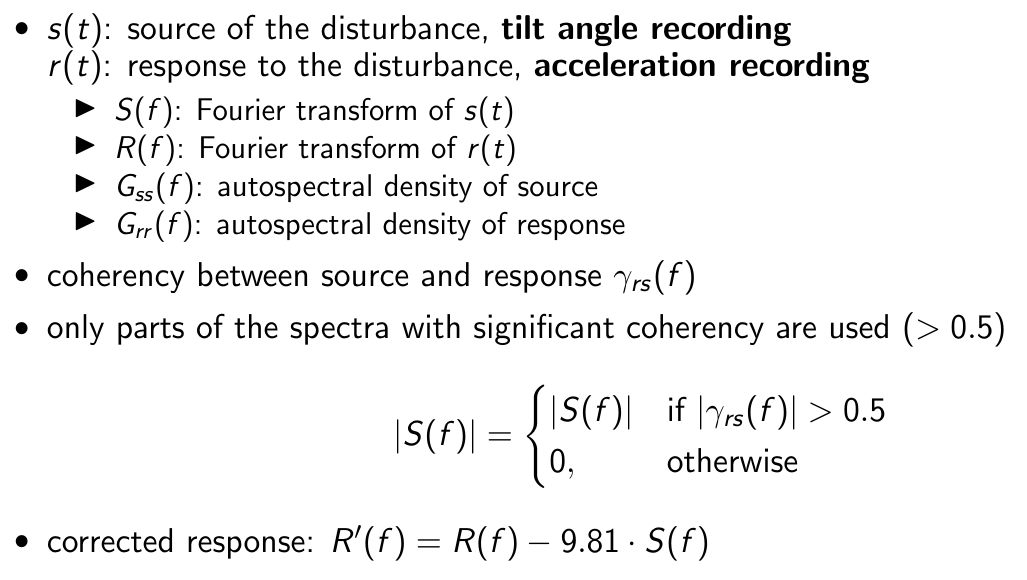


In [1]:
# frequency domain (coh) #
##########################
fmin = -1
fmax = -1
acc_corr_freq1_data, freq_coh, corr_coh, coh_c = remove_tilt_coh(rf1[0].data, ts[0].data,\
                                                                 rf1[0].stats.delta,\
                                                                 rf1[0].stats.npts,\
                                                                 fmin, fmax,\
                                                                 parallel=par) 

acc_corr_freq1 = acc_orig.copy()
acc_corr_freq1[0].data = acc_corr_freq1_data 

acc_corr_freq1.detrend('demean')

vel_corr_freq1 = acc_corr_freq1.copy()
vel_corr_freq1.integrate()
############################################

NameError: name 'remove_tilt_coh' is not defined

Time domain correction: <br>

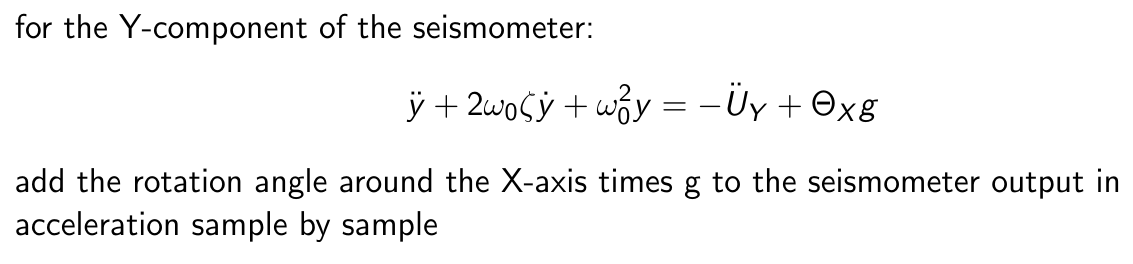

In [ ]:
# time domain #
###############
g = 9.81
acc_corr_time_data = remove_tilt_time(rt[0].data, ts[0].data, g, parallel=par)
acc_corr_time = acc_orig.copy()
acc_corr_time[0].data = acc_corr_time_data 

acc_corr_time.detrend('demean')

vel_corr_time = acc_corr_time.copy()
vel_corr_time.integrate()
############################################

1 Trace(s) in Stream:
XX.TC120..HHN | 2018-12-09T19:48:48.600000Z - 2018-12-09T19:50:41.400000Z | 200.0 Hz, 22561 samples

Let's play a game: <br>
From the displacement left over after tilt correction, we can locale the seismometer mass. <br>



In [7]:
# get the time stamps of the beginning and end of the steps
on, off = trigger(rr_orig[0], 10, 140, 6.0, 5.0, c_on, c_off, S, E, plot_flagg=False)

# define a time axis
sec = np.arange(len(acc_orig[0].data))/(acc_orig[0].stats.sampling_rate)

print(len(on))
print(len(off))

# calculate residual displacement #
###################################
alpha = get_angle(ts, on, off) # angle steps recorded by BS1

# in theory: according to Steffen position of the mass is approximately at the middle of the housing
h_m = 0.0575 #m
h = h_m #m

std_m = 0.01

r, centr = theo_resid_disp(ts[0].data, l, h, dh, rr_orig[0].data)
trr = Stream(traces=Trace(data=r, header=ts[0].stats))
trr.differentiate()
trr_a = trr.copy()
trr_a.differentiate()
time_ttheo, disp_ttheo, mean_disp_ttheo, sigma_ttheo = calc_residual_disp(trr, on, off, np.zeros(len(r)), theo=True)
h_ttheo, std_ttheo = calc_height_of_mass(mean_disp_ttheo, l, dh, alpha)

tcentr = Stream(traces=Trace(data=centr, header=ts[0].stats))
tcentr.detrend('demean')
tcentr.detrend('linear')
tcentr.integrate()
tcentr.detrend('demean')
tcentr.detrend('linear')
tcentr.integrate()

# correct for residual displacement in time domain
acc_corr_time2 = acc_corr_time.copy()
acc_corr_time2[0].data = acc_corr_time2[0].data - trr_a[0].data

vel_corr_time2 = acc_corr_time2.copy()
vel_corr_time2.integrate()

tr1_vel = vel_corr_freq1.copy()
tt_vel = vel_corr_time.copy()
tt2_vel = vel_corr_time2.copy()

tr1_new = vel_corr_freq1.copy()
tt_new = vel_corr_time.copy()
tt2_new = vel_corr_time2.copy()


time_tr1, disp_tr1, mean_disp_tr1, sigma_tr1 = calc_residual_disp(tr1_new, on, off, r)

time_tt, disp_tt, mean_disp_tt, sigma_tt = calc_residual_disp(tt_new, on, off, r)

time_tt2, disp_tt2, mean_disp_tt2, sigma_tt2 = calc_residual_disp(tt2_new, on, off, r)

# calculate the position of the seismometer mass #
##################################################
h_tr1, std_tr1 = calc_height_of_mass(mean_disp_tr1, l, dh, alpha)
h_tt, std_tt = calc_height_of_mass(mean_disp_tt, l, dh, alpha)


disp_corr_freq1 = vel_corr_freq1.copy()
disp_corr_freq1.integrate()

disp_corr_time = vel_corr_time.copy()
disp_corr_time.integrate()

disp_corr_time2 = vel_corr_time2.copy()
disp_corr_time2.integrate()

####################################################
#                     OUTPUT                       #
####################################################
scale = 1.e3
scaled = 1.e6

print('###############################################')
print('mean residual displacement:')
print('frequency domain (coh): '+str(np.round(mean_disp_tr1*scale, 3))+'+/-'+str(np.round(sigma_tr1*scale, 3))+' mm')
print('time domain           : '+str(np.round(mean_disp_tt*scale, 3))+'+/-'+str(np.round(sigma_tt*scale, 3))+' mm')
print('')
print('-----------------------------------------------')
print('height of seismometer mass:')
print('frequency domain (coh): '+str(np.round(h_tr1*scale, 3))+'+/-'+str(np.round(std_tr1*scale, 3))+' mm')
print('time domain           : '+str(np.round(h_tt*scale, 3))+'+/-'+str(np.round(std_tt*scale, 3))+' mm')
print('theoretical           : '+str(np.round(h_ttheo*scale, 3))+'+/-'+str(np.round(std_ttheo*scale, 3))+' mm')
print('measured              : '+str(np.round(h_m*scale, 3))+'+/-'+str(np.round(std_m*scale, 3))+' mm')
print('-----------------------------------------------')
print('')

21
21
###############################################
mean residual displacement:
frequency domain (coh): 0.043+/-0.005 mm
time domain           : 0.043+/-0.005 mm

-----------------------------------------------
height of seismometer mass:
frequency domain (coh): 57.369+/-0.246 mm
time domain           : 57.369+/-0.246 mm
theoretical           : 57.156+/-0.245 mm
measured              : 57.5+/-10.0 mm
-----------------------------------------------



In [8]:
# colors and linestyles
# define colors
al_trig = 0.1

c_trig_on = (0,0,0)
c_trig_off = (0,0,0)

c_angle = (1,0,0)
c_vel = (0,0,0)

c_time = (0,0,1)
c_time2 = (0,0.8,1)
c_coh = (1,0.54,0)
c_freq = (0,0.8,0)

c_tdisp = (0,0,0)

#define linestyles
ls_trig_on = '-'
ls_trig_off = '-'

ls_angle = '-'
ls_vel = '-'

ls_time = '-'
ls_time2 = '--'
ls_coh = '--'
ls_freq = ':'

ls_tdisp = ':'

# define linewidth
lw_trig_on = 2.0
lw_trig_off = 2.0

lw_angle = 2.0
lw_vel = 2.0

lw_time = 1.5
lw_time2 = 1.5
lw_coh = 2.5
lw_freq = 2.5

lw_tdisp = 2.0

#define labels
l_trig = 'step table movement'

l_angle = 'tilt angle'
l_vel = 'NOT corrected'

l_time = 'corr. time domain'
l_time2 = 'corr. time domain with disp'
l_coh = 'corr. frequency domain'
l_freq = 'corr. frequency domain (C\&W2000)'

l_tdisp = 'theo. displacement'
# END colors and linestyles
#############################################################################

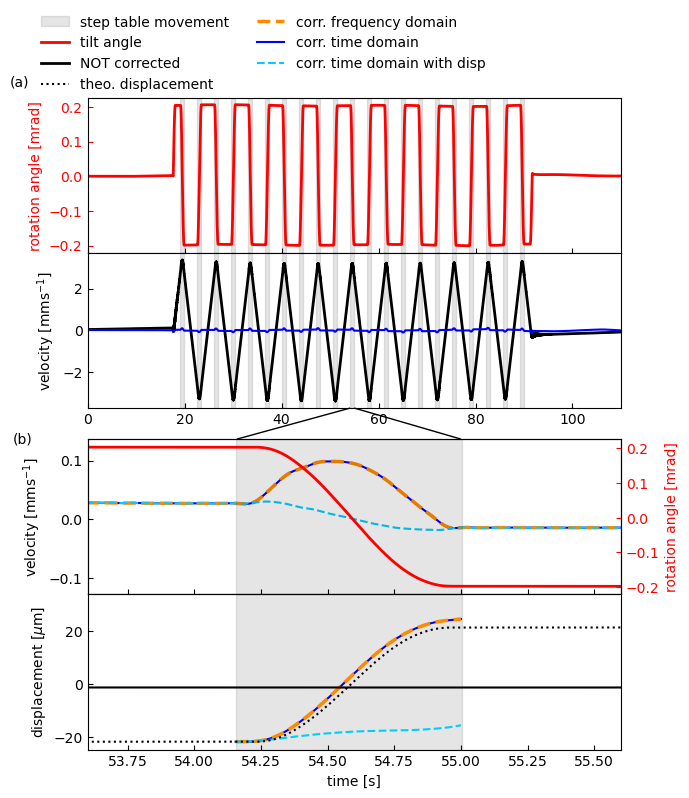

In [9]:
# PLOTS
gridspec = dict(hspace=0.0, height_ratios=[1, 1, 0.2, 1, 1])
fig, axs = plt.subplots(nrows=5, ncols=1, gridspec_kw=gridspec, figsize=(7,8))
axs[2].set_visible(False)

ax0 = axs[0]
ax2 = axs[1]
ax3 = axs[3]
ax31 = ax3.twinx()
ax4 = axs[4]

line_angle, = ax0.plot(sec,ts[0].data*scale, color=c_angle, linestyle=ls_angle, linewidth=lw_angle, label=l_angle)
for i in range(len(on)):
    p_trig = ax0.axvspan(on[i], off[i], alpha=al_trig, color=c_trig_on)

line_vel, = ax2.plot(sec,vel_orig[0].data*scale, color=c_vel, linestyle=ls_vel, linewidth=lw_vel, label=l_vel)
line_time, = ax2.plot(sec,tt_vel[0].data*scale,color=c_time, linestyle=ls_time, linewidth=lw_time, label=l_time)
for i in range(len(on)):
    ax2.axvspan(on[i], off[i], alpha=al_trig, color=c_trig_on)

line_angle, = ax31.plot(sec,ts[0].data*scale, color=c_angle, linestyle=ls_angle, linewidth=lw_angle, label=l_angle)
for i in range(len(on)):
    p_trig = ax31.axvspan(on[i], off[i], alpha=al_trig, color=c_trig_on)

line_time, = ax3.plot(sec,tt_vel[0].data*scale,color=c_time, linestyle=ls_time, linewidth=lw_time, label=l_time)
line_coh, = ax3.plot(sec,tr1_vel[0].data*scale, color=c_coh, linestyle=ls_coh, linewidth=lw_coh, label=l_coh)
line_time2, = ax3.plot(sec,vel_corr_time2[0].data*scale,color=c_time2, linestyle=ls_time2, linewidth=lw_time2, label=l_time2)

for i in range(len(on)):
    ax4.axvspan(on[i], off[i], alpha=al_trig, color=c_trig_on)
    line_time_d, = ax4.plot(time_tt[i], disp_tt[i]*scaled, color=c_time, linestyle=ls_time, linewidth=lw_time, label=l_time)
    line_coh_d, = ax4.plot(time_tr1[i], disp_tr1[i]*scaled, color=c_coh, linestyle=ls_coh, linewidth=lw_coh, label=l_coh)
    line_time_d2, = ax4.plot(time_tt2[i], disp_tt2[i]*scaled, color=c_time2, linestyle=ls_time2, linewidth=lw_time2, label=l_time2)
line_theo_d, = ax4.plot(sec, r*scaled, color=c_tdisp, linestyle=ls_tdisp, label=l_tdisp)
line_centr, = ax4.plot(sec, tcentr[0].data*scaled, color=c_tdisp, linestyle='-', label=l_tdisp)



ax0.set_ylabel('rotation angle [mrad]', color=c_angle)

ax2.set_ylabel('velocity [mms$^{-1}$]')
ax3.set_ylabel('velocity [mms$^{-1}$]')
ax31.set_ylabel('rotation angle [mrad]', color=c_angle)

ax4.set_ylabel('displacement [$\mu$m]')
ax4.set_xlabel('time [s]')

ax0.tick_params('y', colors=c_angle)
ax31.tick_params('y', colors=c_angle)

ax0.tick_params(direction='in')
ax2.tick_params(direction='in')
ax3.tick_params(direction='in')
ax31.tick_params(direction='in')
ax4.tick_params(direction='in')

ax0.set_xticklabels([])
ax31.set_xticklabels([])
ax3.set_xticklabels([])

ax0.text(-16, 0.26, '(a)')
ax3.text(53.32, 0.13, '(b)')

# legend
ba = (-0.098,3.2)
lines = (p_trig, line_angle, line_vel, line_theo_d, line_coh, line_time, line_time2)
labels = (l_trig, l_angle, l_vel, l_tdisp, l_coh, l_time, l_time2)
plt.legend(lines, labels,
            loc=ba,
            bbox_transform=None,
            #bbox_to_anchor=ba,
            borderaxespad=0.,
            frameon=False,
            ncol = 2)

ax0.set_xlim(zoom00, zoom01)
ax2.set_xlim(zoom00, zoom01)
ax3.set_xlim(zoom0, zoom1)
ax31.set_xlim(zoom0, zoom1)
ax4.set_xlim(zoom0, zoom1)


plt.subplots_adjust(
top=0.868,
bottom=0.053,
left=0.118,
right=0.88
#hspace=0.14,
#wspace=0.2
)

zoom_effect01(ax2, ax3, 54.16, 55.00)

plt.show()